## preparation

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import *

import warnings
warnings.filterwarnings('ignore')

In [35]:
spark = SparkSession.builder.appName("ass4_q2").getOrCreate()

# data preprocess


## read data

In [36]:
df = spark.read.csv("./data/Q2_customer_data.csv", header=True, inferSchema=True)

In [37]:
df.show(4,truncate=False)

+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate   |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/1/2010 8:26|2.55     |17850     |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6       |12/1/2010 8:26|3.39     |17850     |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |12/1/2010 8:26|2.75     |17850     |United Kingdom|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |12/1/2010 8:26|3.39     |17850     |United Kingdom|
+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+
only showing top 4 rows



In [38]:
df.printSchema()
df.count()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



541909

Considering two numerical columns be used in the clustering.

## check the missing value

In [39]:
from pyspark.sql.functions import col, sum

missing_values = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing_values.show()

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|        0|        0|       1454|       0|          0|        0|    135080|      0|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



In [40]:
# 创建一个条件，该条件为真当任何列包含空值
condition = col(df.columns[0]).isNull()
for column in df.columns[1:]:
    condition = condition | col(column).isNull()

# 使用该条件过滤 DataFrame
df.filter(condition).show(5)

+---------+---------+--------------------+--------+---------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|    InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+---------------+---------+----------+--------------+
|   536414|    22139|                NULL|      56|12/1/2010 11:52|      0.0|      NULL|United Kingdom|
|   536544|    21773|DECORATIVE ROSE B...|       1|12/1/2010 14:32|     2.51|      NULL|United Kingdom|
|   536544|    21774|DECORATIVE CATS B...|       2|12/1/2010 14:32|     2.51|      NULL|United Kingdom|
|   536544|    21786|  POLKADOT RAIN HAT |       4|12/1/2010 14:32|     0.85|      NULL|United Kingdom|
|   536544|    21787|RAIN PONCHO RETRO...|       2|12/1/2010 14:32|     1.66|      NULL|United Kingdom|
+---------+---------+--------------------+--------+---------------+---------+----------+--------------+
only showing top 5 rows



Even though there are more than 20% samples with missing values, there is no need to drop them as the numerical columns are not impacted by them.

## summary statistic

In [41]:
numerical_columns = ["Quantity","UnitPrice"]

In [42]:
df.select([col(x) for x in numerical_columns]).summary().show()

+-------+------------------+-----------------+
|summary|          Quantity|        UnitPrice|
+-------+------------------+-----------------+
|  count|            541909|           541909|
|   mean|  9.55224954743324|4.611113626089251|
| stddev|218.08115785023375|96.75985306117946|
|    min|            -80995|        -11062.06|
|    25%|                 1|             1.25|
|    50%|                 3|             2.08|
|    75%|                10|             4.13|
|    max|             80995|          38970.0|
+-------+------------------+-----------------+



There are negative numbers in `Quantity` and `UnitPrice`, which are not reasonable. We need to check them.

In [43]:
df.withColumn("is_cancel", when(col("InvoiceNo").startswith("C"), 1).otherwise(0))\
    .withColumn("neg_quantity", when(col("Quantity") < 0, 1).otherwise(0))\
    .withColumn("neg_unitprice",when(col("UnitPrice") < 0, 1).otherwise(0))\
    .agg(sum("is_cancel").alias("# of canceled order"),sum("neg_quantity").alias("# of quantity(<0)"), sum("neg_unitprice").alias("# of UnitPrice(<0)"))\
    .show()

+-------------------+-----------------+------------------+
|# of canceled order|# of quantity(<0)|# of UnitPrice(<0)|
+-------------------+-----------------+------------------+
|               9288|            10624|                 2|
+-------------------+-----------------+------------------+



From the table above, we can see that there are 9288 canceled orders, 10624 orders with quantity less than 0, and 2 orders with unit price less than 0. The preliminary judgment is that the negative values are caused by the cancellation of orders. But the number of negative values in `UnitPrice` are in large gap between number of quantity(<0), which is not reasonable. For these orders, I will drop the rows with negative values in `UnitPrice` but keep the rows with negative values in `Quantity` as they contain the information of the cancellation of orders.

In [44]:
# neg_condition = (col("Quantity") < 0)| (col("UnitPrice")<0 )
df_cleaned = df.filter(~ (col("UnitPrice")<0))
df_cleaned.select([col(x) for x in numerical_columns]).summary().show()
df_cleaned.count()

+-------+------------------+-----------------+
|summary|          Quantity|        UnitPrice|
+-------+------------------+-----------------+
|  count|            541907|           541907|
|   mean| 9.552281110965534|4.651957059053307|
| stddev|218.08155966451855| 94.3954467981491|
|    min|            -80995|              0.0|
|    25%|                 1|             1.25|
|    50%|                 3|             2.08|
|    75%|                10|             4.13|
|    max|             80995|          38970.0|
+-------+------------------+-----------------+



541907

However, there are still some values are much larger than the others, which may be outliers. For instance, the 75% quantile of `Quantity` is 10, but the maximum is 80995. A further check is needed. 

In [45]:
df_cleaned.select("*").orderBy("Quantity","UnitPrice",ascending=False).show(8,truncate=False)
df_cleaned.select("*").orderBy("UnitPrice","Quantity",ascending=False).show(8,truncate=False)

+---------+---------+---------------------------------+--------+----------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                      |Quantity|InvoiceDate     |UnitPrice|CustomerID|Country       |
+---------+---------+---------------------------------+--------+----------------+---------+----------+--------------+
|581483   |23843    |PAPER CRAFT , LITTLE BIRDIE      |80995   |12/9/2011 9:15  |2.08     |16446     |United Kingdom|
|541431   |23166    |MEDIUM CERAMIC TOP STORAGE JAR   |74215   |1/18/2011 10:01 |1.04     |12346     |United Kingdom|
|578841   |84826    |ASSTD DESIGN 3D PAPER STICKERS   |12540   |11/25/2011 15:57|0.0      |13256     |United Kingdom|
|542504   |37413    |NULL                             |5568    |1/28/2011 12:03 |0.0      |NULL      |United Kingdom|
|573008   |84077    |WORLD WAR 2 GLIDERS ASSTD DESIGNS|4800    |10/27/2011 12:26|0.21     |12901     |United Kingdom|
|554868   |22197    |SMALL POPCORN HOLDER             |4

+---------+---------+-----------+--------+---------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate    |UnitPrice|CustomerID|Country       |
+---------+---------+-----------+--------+---------------+---------+----------+--------------+
|C556445  |M        |Manual     |-1      |6/10/2011 15:31|38970.0  |15098     |United Kingdom|
|C580605  |AMAZONFEE|AMAZON FEE |-1      |12/5/2011 11:36|17836.46 |NULL      |United Kingdom|
|C540117  |AMAZONFEE|AMAZON FEE |-1      |1/5/2011 9:55  |16888.02 |NULL      |United Kingdom|
|C540118  |AMAZONFEE|AMAZON FEE |-1      |1/5/2011 9:57  |16453.71 |NULL      |United Kingdom|
|537632   |AMAZONFEE|AMAZON FEE |1       |12/7/2010 15:08|13541.33 |NULL      |United Kingdom|
|C537630  |AMAZONFEE|AMAZON FEE |-1      |12/7/2010 15:04|13541.33 |NULL      |United Kingdom|
|C537651  |AMAZONFEE|AMAZON FEE |-1      |12/7/2010 15:49|13541.33 |NULL      |United Kingdom|
|C537644  |AMAZONFEE|AMAZON FEE |-1      |12/7/201

For the first table, we can see that the top 2 value of `Quantity` is 80995 and 74215, which are much larger than the others. So that we can remove them by 1.5 IQR criteria.

In [46]:
IQR_Quantity = df_cleaned.approxQuantile("Quantity", [0.25, 0.75], 0)
IQR_UnitPrice = df_cleaned.approxQuantile("UnitPrice", [0.25, 0.75], 0)

outerfence_Quantity = [IQR_Quantity[0] - 1.5 * (IQR_Quantity[1] - IQR_Quantity[0]), IQR_Quantity[1] + 1.5 * (IQR_Quantity[1] - IQR_Quantity[0])]
outerfence_UnitPrice = [IQR_UnitPrice[0] - 1.5 * (IQR_UnitPrice[1] - IQR_UnitPrice[0]), IQR_UnitPrice[1] + 1.5 * (IQR_UnitPrice[1] - IQR_UnitPrice[0])]

In [47]:
outlier_condition = (col("Quantity") < outerfence_Quantity[0]) | (col("Quantity") > outerfence_Quantity[1]) | (col("UnitPrice") < outerfence_UnitPrice[0]) | (col("UnitPrice") > outerfence_UnitPrice[1])
df_cleaned = df_cleaned.filter(~outlier_condition)
df_cleaned.select([col(x) for x in numerical_columns]).summary().show()
df_cleaned.count()

+-------+-----------------+------------------+
|summary|         Quantity|         UnitPrice|
+-------+-----------------+------------------+
|  count|           444108|            444108|
|   mean|4.803065920902123|2.6945441739394593|
| stddev|4.616762324084414|1.9303203338074977|
|    min|              -12|               0.0|
|    25%|                1|              1.25|
|    50%|                3|              2.08|
|    75%|                8|              3.75|
|    max|               23|              8.33|
+-------+-----------------+------------------+



444108

# Q2 (1)

In [48]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.pipeline import Pipeline

assembler = VectorAssembler(inputCols=numerical_columns, outputCol="features")
standardizer = StandardScaler(withMean=True, withStd=True, inputCol="features", outputCol="stdFeatures")

process_pipeline = Pipeline(stages=[assembler, standardizer])
pre_df_cleaned = process_pipeline.fit(df_cleaned).transform(df_cleaned)

In [49]:
pre_df_cleaned.select("Quantity","UnitPrice","features","stdFeatures").show(10,truncate=False)

+--------+---------+----------+-----------------------------------------+
|Quantity|UnitPrice|features  |stdFeatures                              |
+--------+---------+----------+-----------------------------------------+
|6       |2.55     |[6.0,2.55]|[0.2592583276062945,-0.07488092593137735]|
|6       |3.39     |[6.0,3.39]|[0.2592583276062945,0.36028000839040214] |
|8       |2.75     |[8.0,2.75]|[0.6924623480009626,0.02872882033571306] |
|6       |3.39     |[6.0,3.39]|[0.2592583276062945,0.36028000839040214] |
|6       |3.39     |[6.0,3.39]|[0.2592583276062945,0.36028000839040214] |
|2       |7.65     |[2.0,7.65]|[-0.6071497131830418,2.5671676038794264] |
|6       |4.25     |[6.0,4.25]|[0.2592583276062945,0.8058019173388905]  |
|6       |1.85     |[6.0,1.85]|[0.2592583276062945,-0.43751503786619333]|
|6       |1.85     |[6.0,1.85]|[0.2592583276062945,-0.43751503786619333]|
|6       |2.1      |[6.0,2.1] |[0.2592583276062945,-0.30800285503233044]|
+--------+---------+----------+-------

In [50]:
trainingCost = []
silhouettes = []

for k in range(2, 11):  # 尝试从 2 到 10 的簇数量
    kmeans = KMeans(featuresCol="stdFeatures", k=k, maxIter = 50 , seed=42)
    model = kmeans.fit(pre_df_cleaned)
    predictions = model.transform(pre_df_cleaned)
    evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='stdFeatures')
    silhouette = evaluator.evaluate(predictions)
    silhouettes.append(silhouette)
    trainingCost.append(model.summary.trainingCost)

In [51]:
silhouettes

[0.5458268039236094,
 0.6871354852370154,
 0.646704081357771,
 0.5777380603047995,
 0.5848953897601884,
 0.49474524640635575,
 0.602231271354838,
 0.6006812083955605,
 0.5865990071750675]

In [52]:
best_k = silhouettes.index(np.max(silhouettes)) + 2  # 选择最大轮廓系数对应的簇数量
best_k

3

<Figure size 640x480 with 0 Axes>

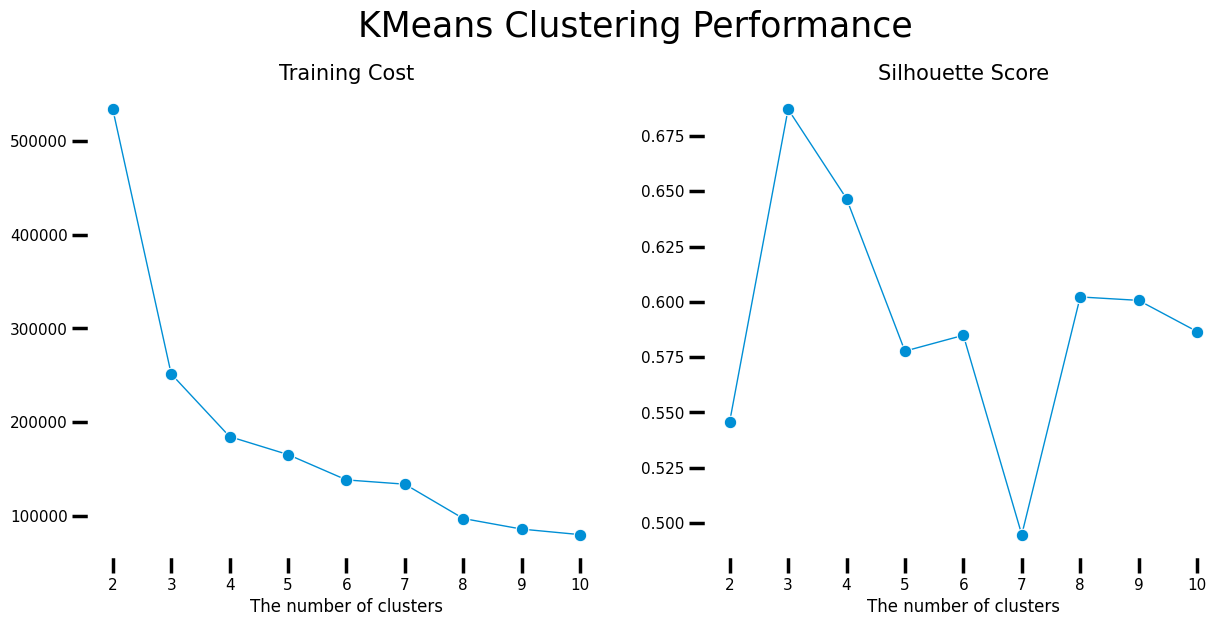

In [53]:
with plt.style.context("fivethirtyeight"), sns.plotting_context(context="poster",font_scale=0.5):
    fig, axes = plt.subplots(1,2,figsize=(13, 6))
    fig.patch.set_facecolor('white')  # 设置整个图的背景颜色为白色

    plt.suptitle('KMeans Clustering Performance', size = 25)
    plt.subplots_adjust(top=0.85)

    sns.lineplot(x=range(2, 11), y=trainingCost, ax=axes[0],linewidth=1,marker = "o",markersize = 9)
    axes[0].set_title("Training Cost", size = 15)
    axes[0].set_xlabel("The number of clusters")
    axes[0].grid(False)
    sns.lineplot(x=range(2, 11), y=silhouettes, ax=axes[1],linewidth=1,marker = "o",markersize = 9)
    axes[1].set_title("Silhouette Score", size = 15)
    axes[1].set_xlabel("The number of clusters")
    axes[1].grid(False)
    
    
    for ax in axes:
        ax.set_facecolor('white')    # 设置轴的边框颜色为白色
        for spine in ax.spines.values():
            spine.set_edgecolor('white')
plt.show()
plt.savefig("report/figure/kmeans_performance.svg",bbox_inches="tight",transparent=True)

In clustering algorithms, trainingCost is often used to indicate how well a model fits. In K-means clustering, trainingCost usually refers to the sum of the Euclidean distances from all data points to the center of the cluster to which they belong, also known as WCSS (Within-Cluster Sum of Square). This is a measure of clustering effect, the smaller the value, the better the clustering effect.    However, it should be noted that trainingCost does not fully reflect the quality of clustering. Because trainingCost continues to decrease as the number of clusters increases, even when each data point is a cluster, trainingCost drops to zero. However, this does not mean that the clustering effect is getting better and better, on the contrary, overfitting may occur. Therefore, choosing the appropriate number of clusters is an important problem in clustering.

Silhouette coefficient is an index to evaluate clustering effect, which considers both cohesion and separation of clustering.  The contour coefficient is calculated as follows: For each sample point, calculate its average distance from all other points in the same cluster. This value is called a and represents the degree of cohesion. Then calculate the average distance between this sample point and all points in the other clusters, and choose the smallest one as b, which represents the degree of separation. Finally, the profile coefficient s is (b - a) / max(a, b). The profile coefficient has a value between-1 and 1. A value close to 1 indicates that the sample point is very close to the other points in its cluster and very far away from the points in the other clusters, i.e., clustering is good. A value close to-1 indicates poor clustering. A value close to 0 indicates that the sample point is on the boundary of two clusters.

# Q2 (2)

In [54]:
kmeans = KMeans(k=best_k, seed=42, featuresCol='stdFeatures')
model = kmeans.fit(pre_df_cleaned)
predictions = model.transform(pre_df_cleaned).select("Quantity","UnitPrice",'stdFeatures', "prediction")
pdf = predictions.toPandas()

In [55]:
# pdf["prediction"].value_counts()
pdf

,Quantity,UnitPrice,stdFeatures,prediction
0,6,2.55,"[0.2592583276062945, -0.07488092593137735]",2
1,6,3.39,"[0.2592583276062945, 0.36028000839040214]",2
2,8,2.75,"[0.6924623480009626, 0.02872882033571306]",0
3,6,3.39,"[0.2592583276062945, 0.36028000839040214]",2
4,6,3.39,"[0.2592583276062945, 0.36028000839040214]",2
...,...,...,...,...
444103,12,0.85,"[1.558870388790299, -0.9555637692016449]",0
444104,6,2.10,"[0.2592583276062945, -0.30800285503233044]",2
444105,4,4.15,"[-0.17394569278837363, 0.7539970442053455]",1
444106,4,4.15,"[-0.17394569278837363, 0.7539970442053455]",1


<Figure size 640x480 with 0 Axes>

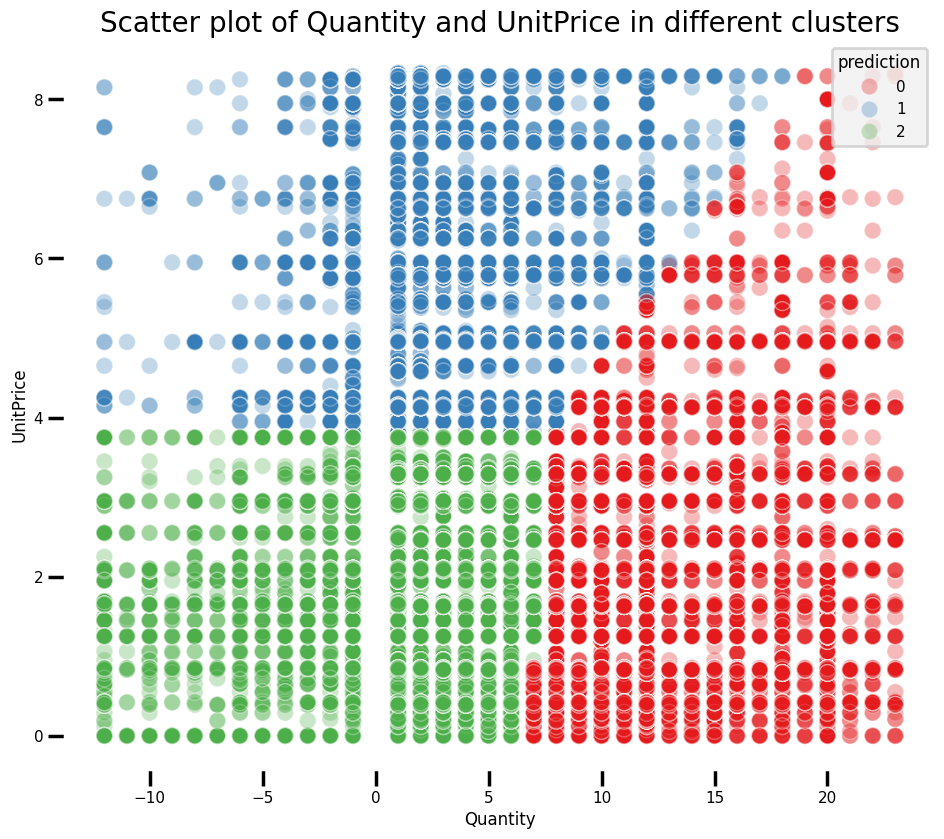

In [56]:
with plt.style.context("fivethirtyeight"), sns.plotting_context(context="poster",font_scale=0.5):
    fig, ax = plt.subplots(figsize=(10, 9))  # 创建一个新的 figure 和一个新的 axes
    sns.scatterplot(data =pdf, x= "Quantity", y = "UnitPrice", hue = "prediction", palette = "Set1", alpha = 0.3) 
    fig.set_facecolor('white')  # 设置整个图的背景颜色为白色
    ax.set_facecolor('white')  # 设置 axes 的背景颜色为白色
    ax.spines['bottom'].set_color('white')  # 设置底部边框颜色为白色
    ax.spines['top'].set_color('white')  # 设置顶部边框颜色为白色
    ax.spines['right'].set_color('white')  # 设置右边边框颜色为白色
    ax.spines['left'].set_color('white')  # 设置左边边框颜色为白色
    plt.title("Scatter plot of Quantity and UnitPrice in different clusters", size = 20)
    # plt.legend(["cluster 1","cluster 2","cluster 3"])
    plt.grid(False)
    plt.show()
    plt.savefig("report/figure/kmeans_cluster.svg",bbox_inches="tight",transparent=True)

<Figure size 640x480 with 0 Axes>

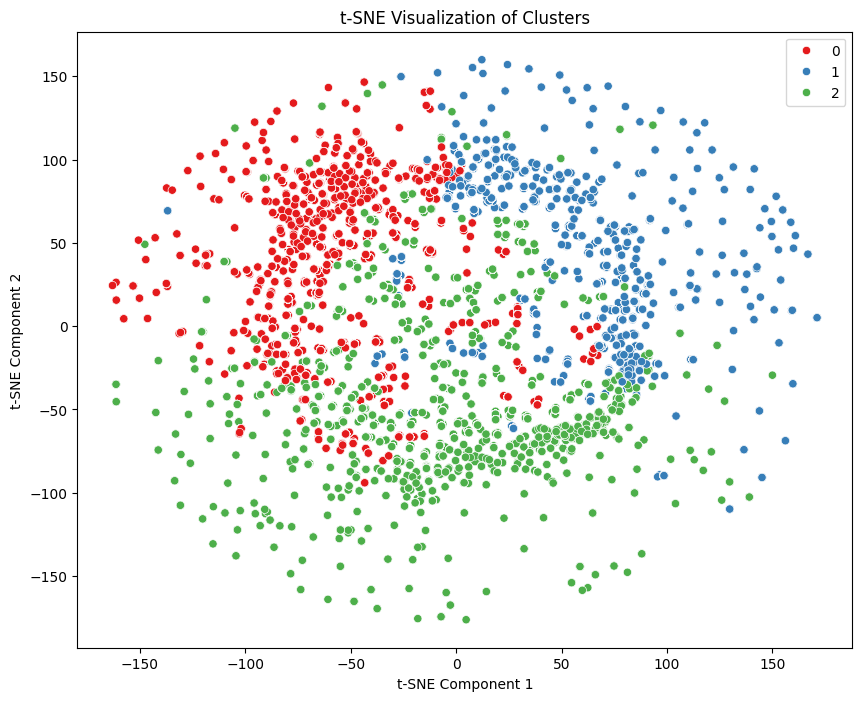

In [57]:
X = np.array([DenseVector.toArray() for DenseVector in pdf['stdFeatures'].values])
clusters = pdf["prediction"].values
tsne = TSNE(n_components=2)
X_embedded = tsne.fit_transform(X)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=clusters, palette='Set1', legend='full')
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()
plt.savefig("report/figure/kmeans_tsne.svg",bbox_inches="tight",transparent=True)

# Q2 (3)

In [58]:
for i in range(best_k):
    print(f"Cluster {i}:")
    predictions.filter(predictions.prediction == i).describe().show()

Cluster 0:
+-------+------------------+------------------+----------+
|summary|          Quantity|         UnitPrice|prediction|
+-------+------------------+------------------+----------+
|  count|            108014|            108014|    108014|
|   mean|11.848241894569222|1.5687047049456841|       0.0|
| stddev|2.7192800191684796|0.9338166679996386|       0.0|
|    min|                 7|               0.0|         0|
|    max|                23|              8.33|         0|
+-------+------------------+------------------+----------+

Cluster 1:


+-------+------------------+------------------+----------+
|summary|          Quantity|         UnitPrice|prediction|
+-------+------------------+------------------+----------+
|  count|            102060|            102060|    102060|
|   mean| 2.519106407995297| 5.606010288065541|       1.0|
| stddev|2.2448861519412926|1.4325111426420263|       0.0|
|    min|               -12|              3.81|         1|
|    max|                18|              8.33|         1|
+-------+------------------+------------------+----------+

Cluster 2:


+-------+------------------+------------------+----------+
|summary|          Quantity|         UnitPrice|prediction|
+-------+------------------+------------------+----------+
|  count|            234034|            234034|    234034|
|   mean|2.5475101908269737|1.9444915866925447|       2.0|
| stddev| 2.136843619284345|0.9639939798703703|       0.0|
|    min|               -12|               0.0|         2|
|    max|                 7|              3.75|         2|
+-------+------------------+------------------+----------+

